In [1]:
!pip install xgboost
!pip install xgboost shap
import xgboost
import shap
print(xgboost.__version__)
print(shap.__version__)


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.1.1
0.50.0


In [2]:
# Step 1. Imports & global config

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore")

# For plots inside Jupyter
%matplotlib inline

# Global style
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42


In [3]:
# Step 2. Load data & train-test split

# Load final processed data
X = pd.read_csv("../data/processed/X_ready.csv")
y = pd.read_csv("../data/processed/y_ready.csv").iloc[:, 0]  # 取出第一欄變成 Series

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y value counts:")
print(y.value_counts(normalize=True))


# Train/Test split keep the same distribution of target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


X shape: (10127, 46)
y shape: (10127,)
y value counts:
Churn_Flag
0    0.83934
1    0.16066
Name: proportion, dtype: float64
Train shape: (8101, 46)
Test shape: (2026, 46)


In [4]:
# Step 3. Helper functions for model evaluation and visualization

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    """
    Evaluate a binary classification model on train and test sets.

    Returns a dictionary with:
        - train_accuracy, test_accuracy
        - train_recall, test_recall
        - train_f1, test_f1
        - train_roc_auc, test_roc_auc (if probabilities/decision scores are available)

    Also prints a classification report for the test set.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities or decision scores for ROC AUC
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    else:
        y_train_proba = None
        y_test_proba = None

    metrics = {}
    metrics["model"] = model_name if model_name else type(model).__name__

    # Basic metrics
    metrics["train_accuracy"] = accuracy_score(y_train, y_train_pred)
    metrics["test_accuracy"] = accuracy_score(y_test, y_test_pred)
    metrics["train_recall"] = recall_score(y_train, y_train_pred)
    metrics["test_recall"] = recall_score(y_test, y_test_pred)
    metrics["train_f1"] = f1_score(y_train, y_train_pred)
    metrics["test_f1"] = f1_score(y_test, y_test_pred)

    # ROC AUC (if we have continuous scores)
    if y_train_proba is not None:
        metrics["train_roc_auc"] = roc_auc_score(y_train, y_train_proba)
        metrics["test_roc_auc"] = roc_auc_score(y_test, y_test_proba)
    else:
        metrics["train_roc_auc"] = np.nan
        metrics["test_roc_auc"] = np.nan

    # Pretty print
    print("=" * 60)
    print(f"Model: {metrics['model']}")
    print("- Train metrics -")
    print(
        f"Accuracy: {metrics['train_accuracy']:.3f}, "
        f"Recall: {metrics['train_recall']:.3f}, "
        f"F1: {metrics['train_f1']:.3f}, "
        f"ROC_AUC: {metrics['train_roc_auc']:.3f}"
    )
    print("- Test metrics -")
    print(
        f"Accuracy: {metrics['test_accuracy']:.3f}, "
        f"Recall: {metrics['test_recall']:.3f}, "
        f"F1: {metrics['test_f1']:.3f}, "
        f"ROC_AUC: {metrics['test_roc_auc']:.3f}"
    )

    print("\nClassification report (Test):")
    print(classification_report(y_test, y_test_pred))

    return metrics


def plot_roc_curves_per_model(models_and_data, y_test):
    """
    Plot ROC curves for multiple models, each with its own X_test.

    Parameters
    ----------
    models_and_data : list of (str, estimator, X_test)
        List of (model_name, trained_model, matching_X_test).
    """
    plt.figure()
    for name, model, X in models_and_data:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X)
        else:
            # Skip models without a continuous score
            continue

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix heatmap for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


Model: Logistic Regression
- Train metrics -
Accuracy: 0.872, Recall: 0.873, F1: 0.686, ROC_AUC: 0.946
- Test metrics -
Accuracy: 0.869, Recall: 0.846, F1: 0.674, ROC_AUC: 0.938

Classification report (Test):
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1701
           1       0.56      0.85      0.67       325

    accuracy                           0.87      2026
   macro avg       0.76      0.86      0.80      2026
weighted avg       0.90      0.87      0.88      2026



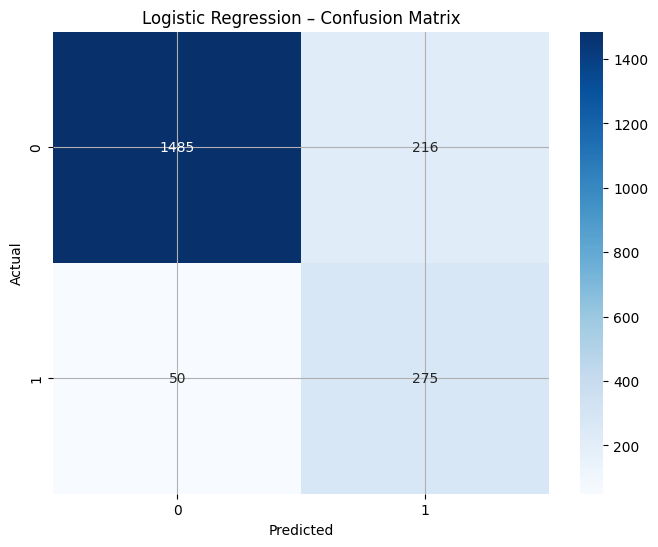

In [5]:
# Step 4. Logistic Regression with StandardScaler pipeline

log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(
        class_weight="balanced",   # handle class imbalance
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Evaluate the model
log_reg_metrics = evaluate_model(
    log_reg_pipeline,
    X_train, y_train,
    X_test, y_test,
    model_name="Logistic Regression"
)

# Confusion Matrix
y_test_pred_lr = log_reg_pipeline.predict(X_test)
plot_confusion_matrix(
    y_test, y_test_pred_lr,
    title="Logistic Regression – Confusion Matrix"
)


Model: Random Forest
- Train metrics -
Accuracy: 0.997, Recall: 1.000, F1: 0.990, ROC_AUC: 1.000
- Test metrics -
Accuracy: 0.956, Recall: 0.825, F1: 0.858, ROC_AUC: 0.987

Classification report (Test):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.89      0.82      0.86       325

    accuracy                           0.96      2026
   macro avg       0.93      0.90      0.92      2026
weighted avg       0.96      0.96      0.96      2026



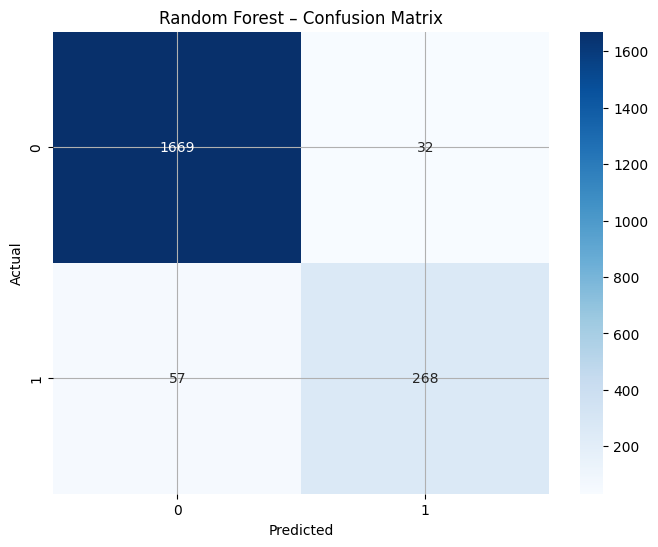

In [6]:
# Step 5. Random Forest

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_metrics = evaluate_model(
    rf_model,
    X_train, y_train,
    X_test, y_test,
    model_name="Random Forest"
)

# Confusion Matrix
y_test_pred_rf = rf_model.predict(X_test)
plot_confusion_matrix(
    y_test, y_test_pred_rf,
    title="Random Forest – Confusion Matrix"
)


Negative: 6799 Positive: 1302 scale_pos_weight: 5.221966205837173
Model: XGBoost
- Train metrics -
Accuracy: 0.983, Recall: 0.995, F1: 0.950, ROC_AUC: 0.999
- Test metrics -
Accuracy: 0.968, Recall: 0.926, F1: 0.903, ROC_AUC: 0.993

Classification report (Test):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1701
           1       0.88      0.93      0.90       325

    accuracy                           0.97      2026
   macro avg       0.93      0.95      0.94      2026
weighted avg       0.97      0.97      0.97      2026



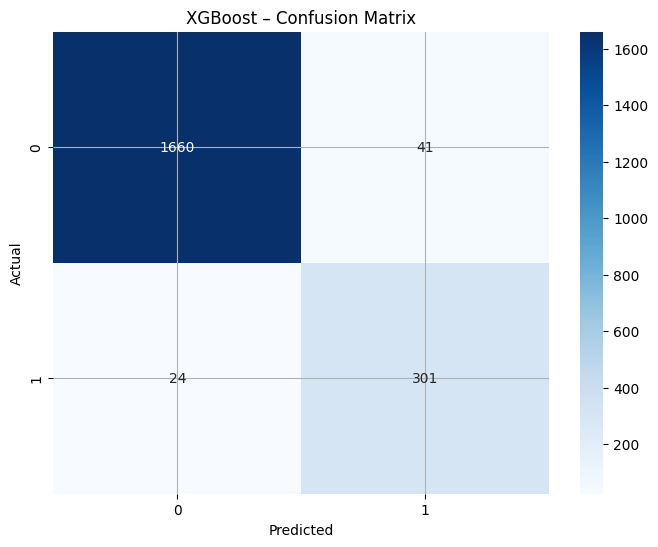

In [7]:
# Step 6. XGBoost

# Create safe copies of X_train and X_test for XGBoost
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

def make_safe_colnames(cols):
    cols = cols.astype(str)
    cols = cols.str.replace("[", "(", regex=False)
    cols = cols.str.replace("]", ")", regex=False)
    cols = cols.str.replace("<", "lt_", regex=False)
    cols = cols.str.replace(">", "gt_", regex=False)
    return cols

safe_cols = make_safe_colnames(X_train_xgb.columns)
X_train_xgb.columns = safe_cols
X_test_xgb.columns = safe_cols

# Compute scale_pos_weight to handle class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Negative:", neg, "Positive:", pos, "scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train_xgb, y_train)

# Evaluate the model
xgb_metrics = evaluate_model(
    xgb_model,
    X_train_xgb, y_train,
    X_test_xgb, y_test,
    model_name="XGBoost"
)

# Confusion Matrix
y_test_pred_xgb = xgb_model.predict(X_test_xgb)
plot_confusion_matrix(
    y_test, y_test_pred_xgb,
    title="XGBoost – Confusion Matrix"
)


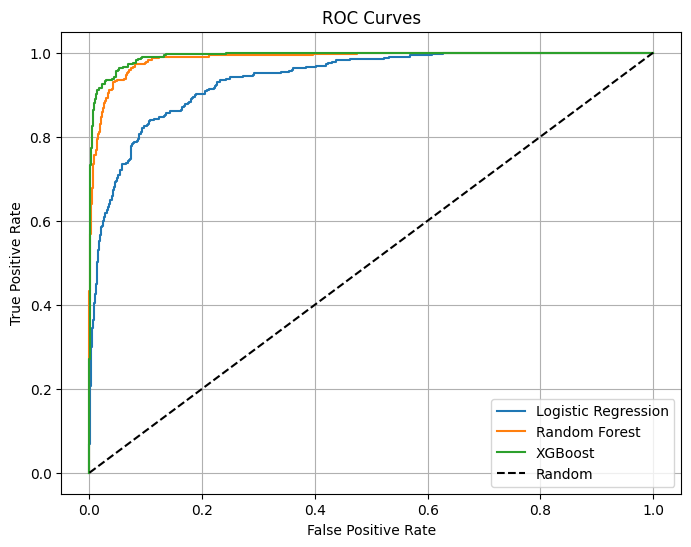

In [8]:
# Step 7. Compare ROC curves (each model uses its own X_test)

models_and_data = [
    ("Logistic Regression", log_reg_pipeline, X_test),
    ("Random Forest", rf_model, X_test),
    ("XGBoost", xgb_model, X_test_xgb),  # uses the safe-column version
]

plot_roc_curves_per_model(models_and_data, y_test)


In [9]:
# Step 8. Create a summary table of model metrics including a baseline

# Baseline: always predict class 0 ("no churn")
baseline_test_accuracy = (y_test == 0).mean()
baseline_train_accuracy = (y_train == 0).mean()

baseline_metrics = {
    "model": "Baseline (always 0)",
    "train_accuracy": baseline_train_accuracy,
    "test_accuracy": baseline_test_accuracy,
    "train_recall": 0.0,      # cannot detect any churn
    "test_recall": 0.0,
    "train_f1": 0.0,
    "test_f1": 0.0,
    "train_roc_auc": 0.5,     # no discrimination ability
    "test_roc_auc": 0.5
}

# Combine baseline with the three models
results = pd.DataFrame([
    baseline_metrics,
    log_reg_metrics,
    rf_metrics,
    xgb_metrics
])

results = results.set_index("model")

# Reorder columns for readability (Version B style)
ordered_cols = [
    "test_accuracy",
    "test_recall",
    "test_f1",
    "test_roc_auc",
    "train_accuracy",
    "train_recall",
    "train_f1",
    "train_roc_auc",
]
results = results[ordered_cols]

# Sort models by test ROC AUC in descending order
results = results.sort_values(by="test_roc_auc", ascending=False)

results.round(3)


,test_accuracy,test_recall,test_f1,test_roc_auc,train_accuracy,train_recall,train_f1,train_roc_auc
model,,,,,,,,
XGBoost,0.968,0.926,0.903,0.993,0.983,0.995,0.950,0.999
Random Forest,0.956,0.825,0.858,0.987,0.997,1.000,0.990,1.000
Logistic Regression,0.869,0.846,0.674,0.938,0.872,0.873,0.686,0.946
Baseline (always 0),0.840,0.000,0.000,0.500,0.839,0.000,0.000,0.500


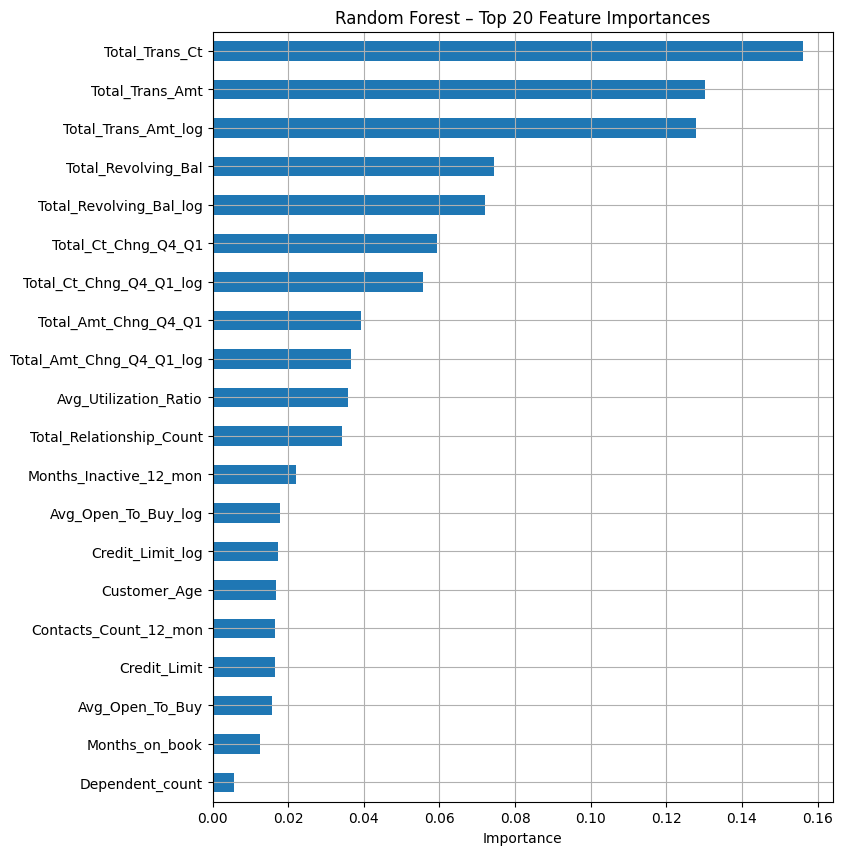

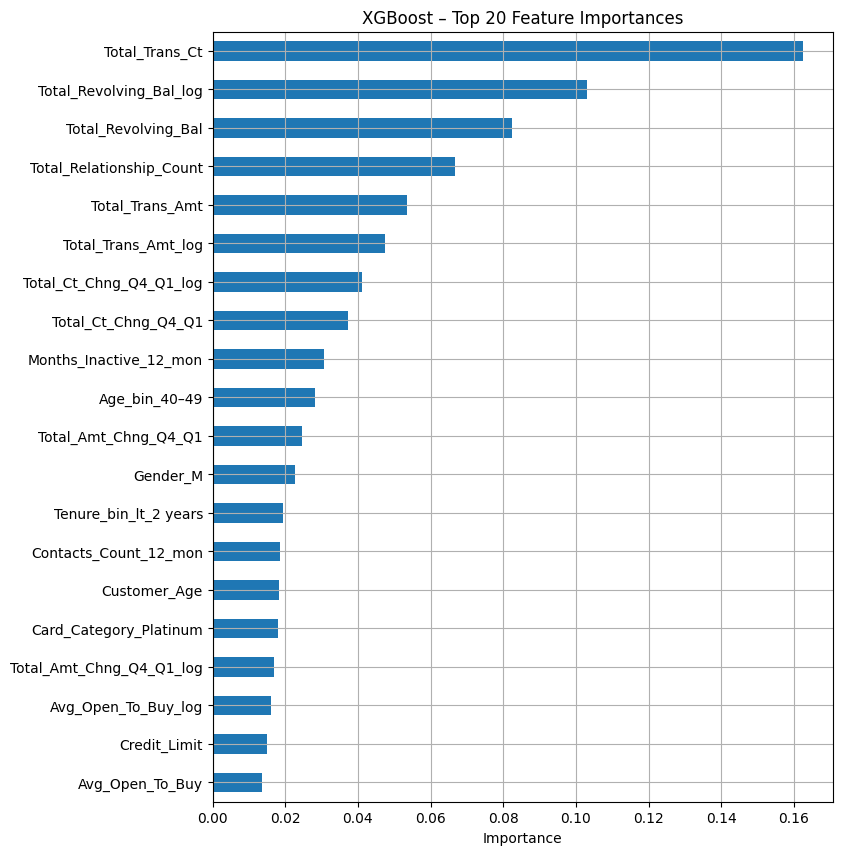

In [10]:
# Step 9-1. Random Forest feature importance

rf_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
rf_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest – Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()


# Step 9-2. XGBoost feature importance (use X_train_xgb)

xgb_importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_xgb.columns    # <-- FIXED HERE
).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
xgb_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost – Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()


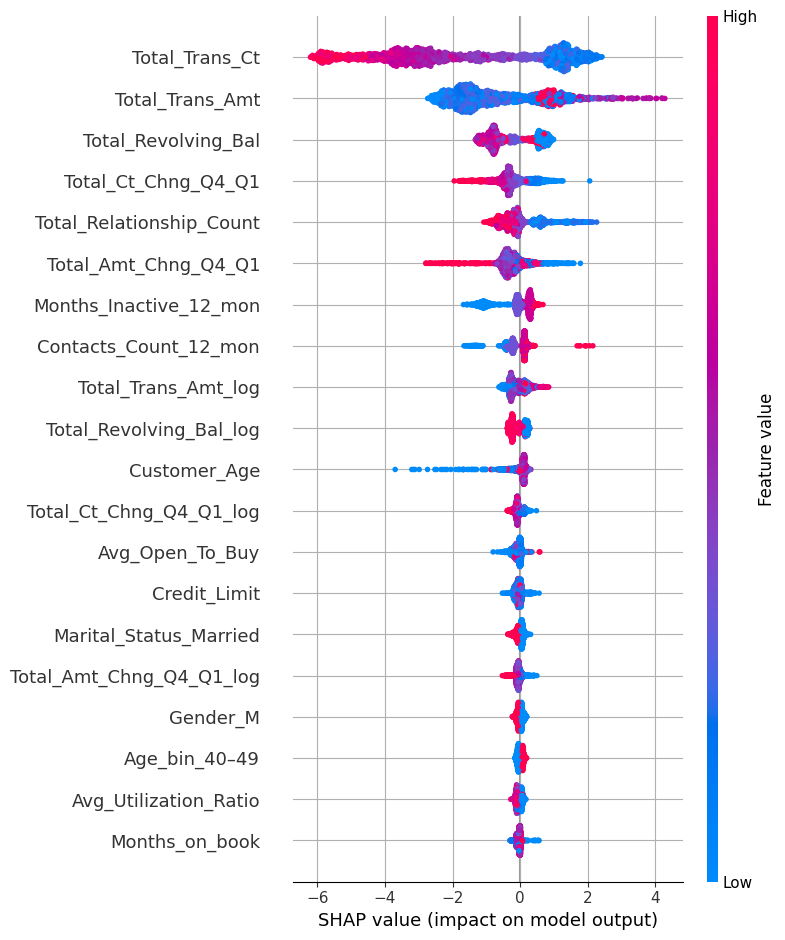

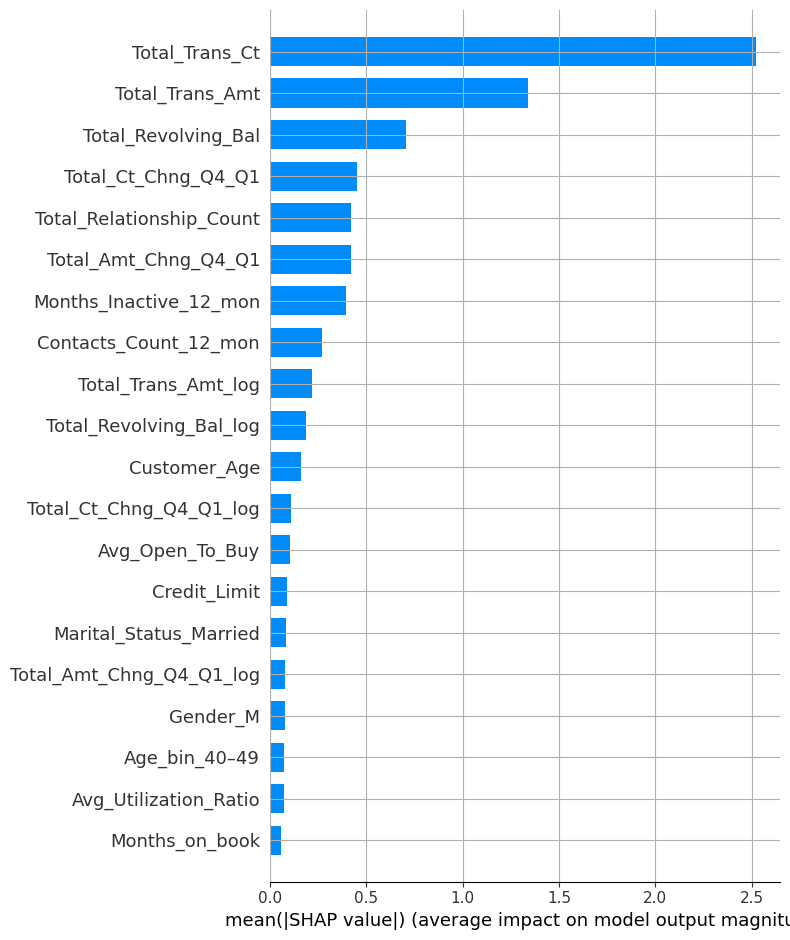

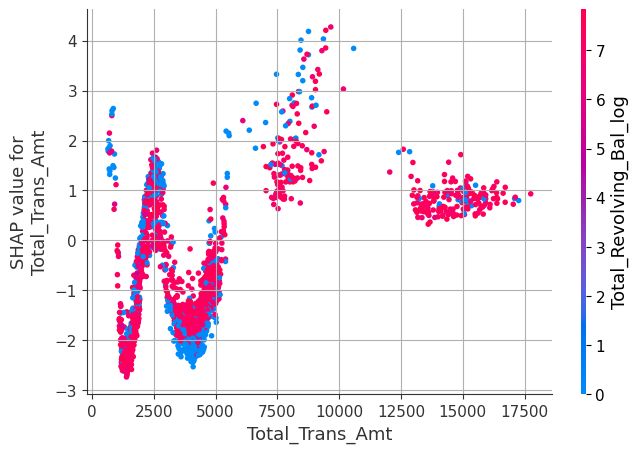

,feature,mean_abs_shap
11,Total_Trans_Ct,2.521507
10,Total_Trans_Amt,1.338719
7,Total_Revolving_Bal,0.704356
12,Total_Ct_Chng_Q4_Q1,0.450532
3,Total_Relationship_Count,0.422019
9,Total_Amt_Chng_Q4_Q1,0.420191
4,Months_Inactive_12_mon,0.395922
5,Contacts_Count_12_mon,0.268313
15,Total_Trans_Amt_log,0.220996
16,Total_Revolving_Bal_log,0.189730


In [12]:
# Step 10. SHAP for XGBoost

# Use the XGB-safe dataset (with sanitized column names)
X_train_shap = X_train_xgb

# Sampling to improve speed
sample_size = 2000
if len(X_train_shap) > sample_size:
    X_train_sample = X_train_shap.sample(sample_size, random_state=RANDOM_STATE)
else:
    X_train_sample = X_train_shap

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sample)

# 1. Summary plot (global importance + direction of impact)
shap.summary_plot(shap_values, X_train_sample)

# 2. Bar plot (mean absolute SHAP values)
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

# 3. Dependency plot for a single feature
# Replace with any feature name from X_train_xgb.columns
shap.dependence_plot("Total_Trans_Amt", shap_values, X_train_sample)

# === Step XX. Export SHAP summary for Power BI ===

import numpy as np
import pandas as pd

# 1. SHAP 可能會輸出 list（如果是 multi-class），所以先統一成 2D array
if isinstance(shap_values, list):
    # 如果 shap_values 是 list，多數情況取針對「churn = 1」的 SHAP（index=1）
    shap_array = shap_values[1]
else:
    shap_array = shap_values

# 2. 計算每個特徵的 mean absolute SHAP
mean_abs_shap = np.abs(shap_array).mean(axis=0)

# 3. 做成 DataFrame
shap_summary = pd.DataFrame({
    "feature": X_train_sample.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# 4. 輸出成 CSV 給 Power BI 使用
shap_summary.to_csv("../data/processed/shap_summary.csv", index=False)

shap_summary.head(10)


SHAP Interpretation — Key Findings

- Transaction frequency and spending intensity are the strongest predictors of churn.
Customers with low Total_Trans_Ct and Total_Trans_Amt show significantly higher churn risk.

- Engagement decline (behavioral deterioration) strongly increases churn.
Features such as Total_Ct_Chng_Q4_Q1 and Total_Amt_Chng_Q4_Q1 show that a drop in activity quarter-over-quarter is a strong signal of potential churn.

- Inactivity indicators consistently push churn risk upward.
Higher Months_Inactive_12_mon or Contacts_Count_12_mon increase predicted churn probability.

- High-value, high-engagement customers are the least likely to churn.
Customers with high spend + high revolving balance cluster on the low-risk side in dependency plots.

- Churn is primarily an engagement problem, not a demographic problem.
Behavioral features dominate; demographic categories contribute very little.

| Rank | Feature                  | Interpretation (Business Meaning)     | Direction            |
| ---- | ------------------------ | ------------------------------------- | -------------------- |
| 1    | Total_Trans_Ct           | Low transaction count = high churn    | Negative correlation |
| 2    | Total_Trans_Amt          | Low spend = high churn                | Negative             |
| 3    | Total_Revolving_Bal      | Low balance = low engagement → churn  | Negative             |
| 4    | Total_Ct_Chng_Q4_Q1      | Activity decline = churn signal       | Negative             |
| 5    | Total_Relationship_Count | Fewer product relationships → churn   | Negative             |
| 6    | Months_Inactive_12_mon   | More inactive months → churn          | Positive             |
| 7    | Contacts_Count_12_mon    | More customer support contact → churn | Positive             |


要拿去做 K-Means 的特徵
| Category                | Variables                                          |
| ----------------------- | -------------------------------------------------- |
| **Engagement level**    | Total_Trans_Ct, Total_Trans_Amt                    |
| **Spending behavior**   | Total_Revolving_Bal, Avg_Open_To_Buy, Credit_Limit |
| **Engagement trend**    | Total_Ct_Chng_Q4_Q1, Total_Amt_Chng_Q4_Q1          |
| **Inactivity behavior** | Months_Inactive_12_mon                             |
| **Risk signals**        | Contacts_Count_12_mon                              |


Why from SHAP to Segmentation?

SHAP identifies which behavioral variables most strongly influence churn.
These same high-impact variables are used in the segmentation stage to build clusters that reflect real customer behavior patterns.
This ensures that K-means clusters are interpretable, business-relevant, and directly actionable for designing retention strategies.